# Harmony and Symphony benchmarking
Comparison of results of R and Python implementations

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc

from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(os.path.dirname(JUPYTER_DIR), "data")

sys.path.append(SYMPHONY_DIR)
sys.path

import symphonypy as sp

['/home/ku/projs/symphony/benchmarking',
 '/home/ku/mambaforge/envs/symphony/lib/python310.zip',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/lib-dynload',
 '',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages',
 '/home/ku/projs/symphony']

In [4]:
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

In [5]:
adata = sc.read_h5ad(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))
adata.layers["counts"] = adata.X.copy()

In [6]:
# Preprocessing

n_comps = 30
max_value = 10
n_neighbors = 21

adata.var_names_make_unique()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="donor")
adata.raw = adata
sc.pp.scale(adata, max_value=max_value)
sc.pp.pca(adata, n_comps=n_comps)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


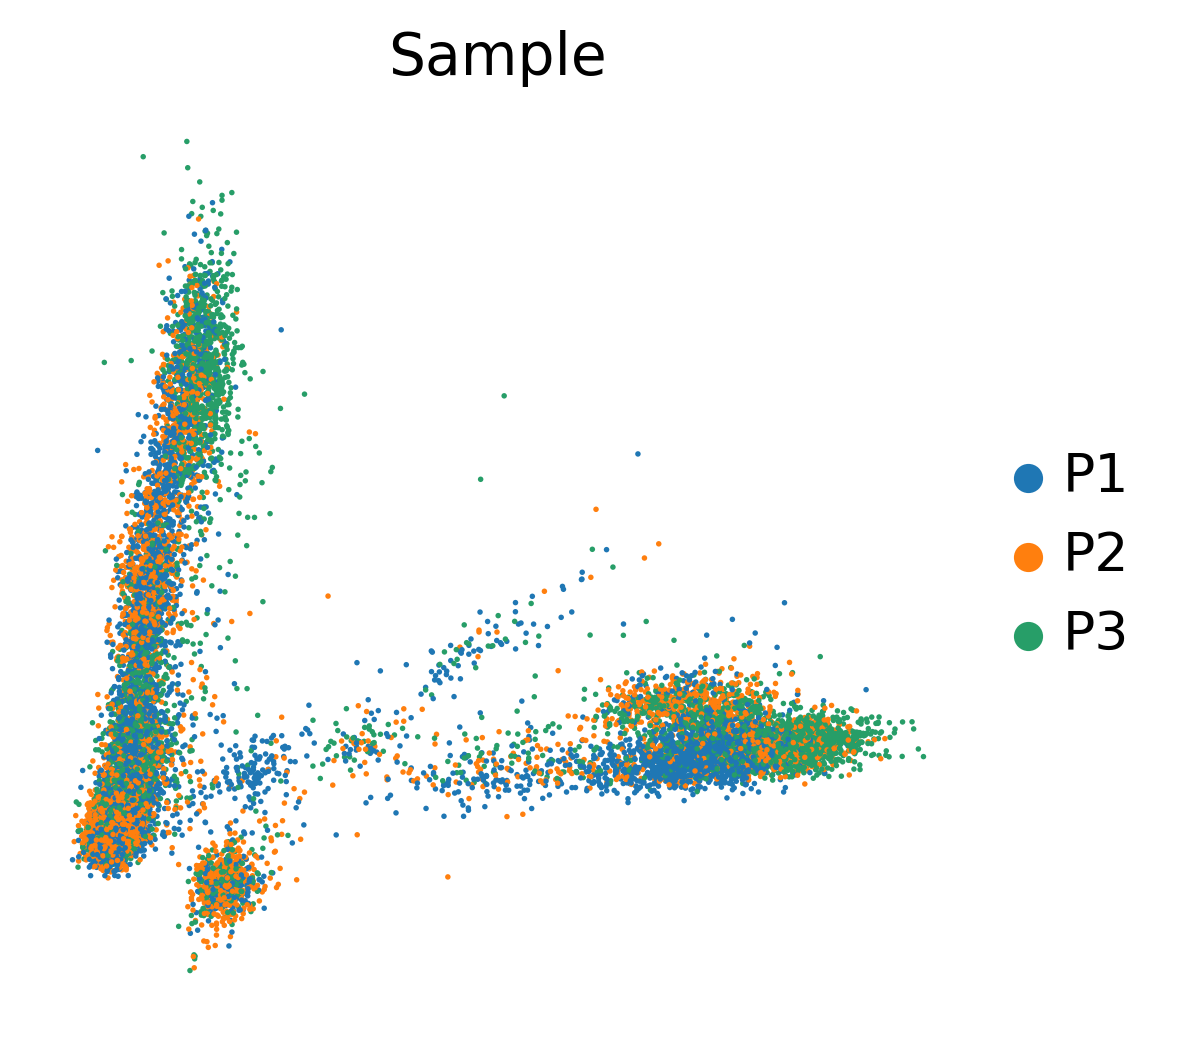

In [7]:
sc.pl.pca(adata, color="donor", frameon=False, title="Sample")

In [8]:
my_pca_embeddings = adata.obsm["X_pca"].copy()
meta_data = adata.obs.copy()

In [9]:
random_seed = 1

## Harmony

**Harmonypy defaults:**  
    theta = 1,  
    lamb = 1,  
    sigma = 0.1,   
    nclust = min(round(N / 30.0), 100),  
    tau = 0,  
    block_size = 0.05,   
    max_iter_kmeans = 20,  
    epsilon_cluster = 1e-5,  
    epsilon_harmony = 1e-4,   
    
**Harmony R defaults:**  
    theta = 2,  
    lambda = 1,  
    sigma = 0.1,  
    nclust = min(round(N / 30), 100),  
    tau = 0,  
    block.size = 0.05,  
    max.iter.harmony = 10,  
    max.iter.cluster = 20,  
    epsilon.cluster = 1e-5,  
    epsilon.harmony = 1e-4,  

In [10]:
common_kwargs = {
    "theta": 2,
    "sigma": 0.1,
    "nclust": 100,
    "tau": 0
}

R_kwargs = {
    "lambda": 1,
    "block.size": 0.05,
    "max.iter.cluster": 20,
    "epsilon.cluster": 1e-5,
    "epsilon.harmony": 1e-4
}

py_kwargs = {
    "lamb": 1,
    "block_size": 0.05, 
    "max_iter_kmeans": 20,
    "epsilon_cluster": 1e-5,
    "epsilon_harmony": 1e-4, 
}

### Harmony R

In [14]:
R_kwargs["max.iter.harmony"] = 20

sp._utils._harmony_integrate_R(
    adata,
    key="donor",
    adjusted_basis="X_pca_harmony_R",
    random_seed=random_seed,
    verbose=True,
    **common_kwargs,
    **R_kwargs
)

Harmony 1/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 4/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 5/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 6/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
********************

### Harmonypy

In [17]:
import harmonypy
ho = harmonypy.run_harmony(
    my_pca_embeddings, 
    meta_data,
    "donor",
    max_iter_harmony=20,
    random_state=random_seed,
    **common_kwargs,
    **py_kwargs
)

2023-01-04 21:39:25,032 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-04 21:39:27,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-04 21:39:27,474 - harmonypy - INFO - Iteration 1 of 20
2023-01-04 21:39:34,474 - harmonypy - INFO - Iteration 2 of 20
2023-01-04 21:39:41,231 - harmonypy - INFO - Iteration 3 of 20
2023-01-04 21:39:48,924 - harmonypy - INFO - Iteration 4 of 20
2023-01-04 21:39:55,970 - harmonypy - INFO - Iteration 5 of 20
2023-01-04 21:40:00,051 - harmonypy - INFO - Iteration 6 of 20
2023-01-04 21:40:04,226 - harmonypy - INFO - Iteration 7 of 20
2023-01-04 21:40:09,069 - harmonypy - INFO - Iteration 8 of 20
2023-01-04 21:40:12,753 - harmonypy - INFO - Iteration 9 of 20
2023-01-04 21:40:15,429 - harmonypy - INFO - Iteration 10 of 20
2023-01-04 21:40:17,237 - harmonypy - INFO - Converged after 10 iterations


In [18]:
adata.obsm["X_pca_harmony_Python"] = ho.Z_corr.copy().T

### Harmony R vs Harmonypy

In [19]:
# Compute neighbors
sc.pp.neighbors(adata, use_rep="X_pca_harmony_R", key_added="Harmony_R", n_neighbors=n_neighbors)
sc.pp.neighbors(adata, use_rep="X_pca_harmony_Python", key_added="Harmony_Python", n_neighbors=n_neighbors)

In [20]:
# Compare number of same neighbors for each cell
def compare_neighbors(adata, obsp1, obsp2):
    return ((adata.obsp[obsp1] > 0).multiply((adata.obsp[obsp2]) > 0)).sum(axis=1)

In [21]:
n_same = compare_neighbors(adata, "Harmony_R_distances", "Harmony_Python_distances")

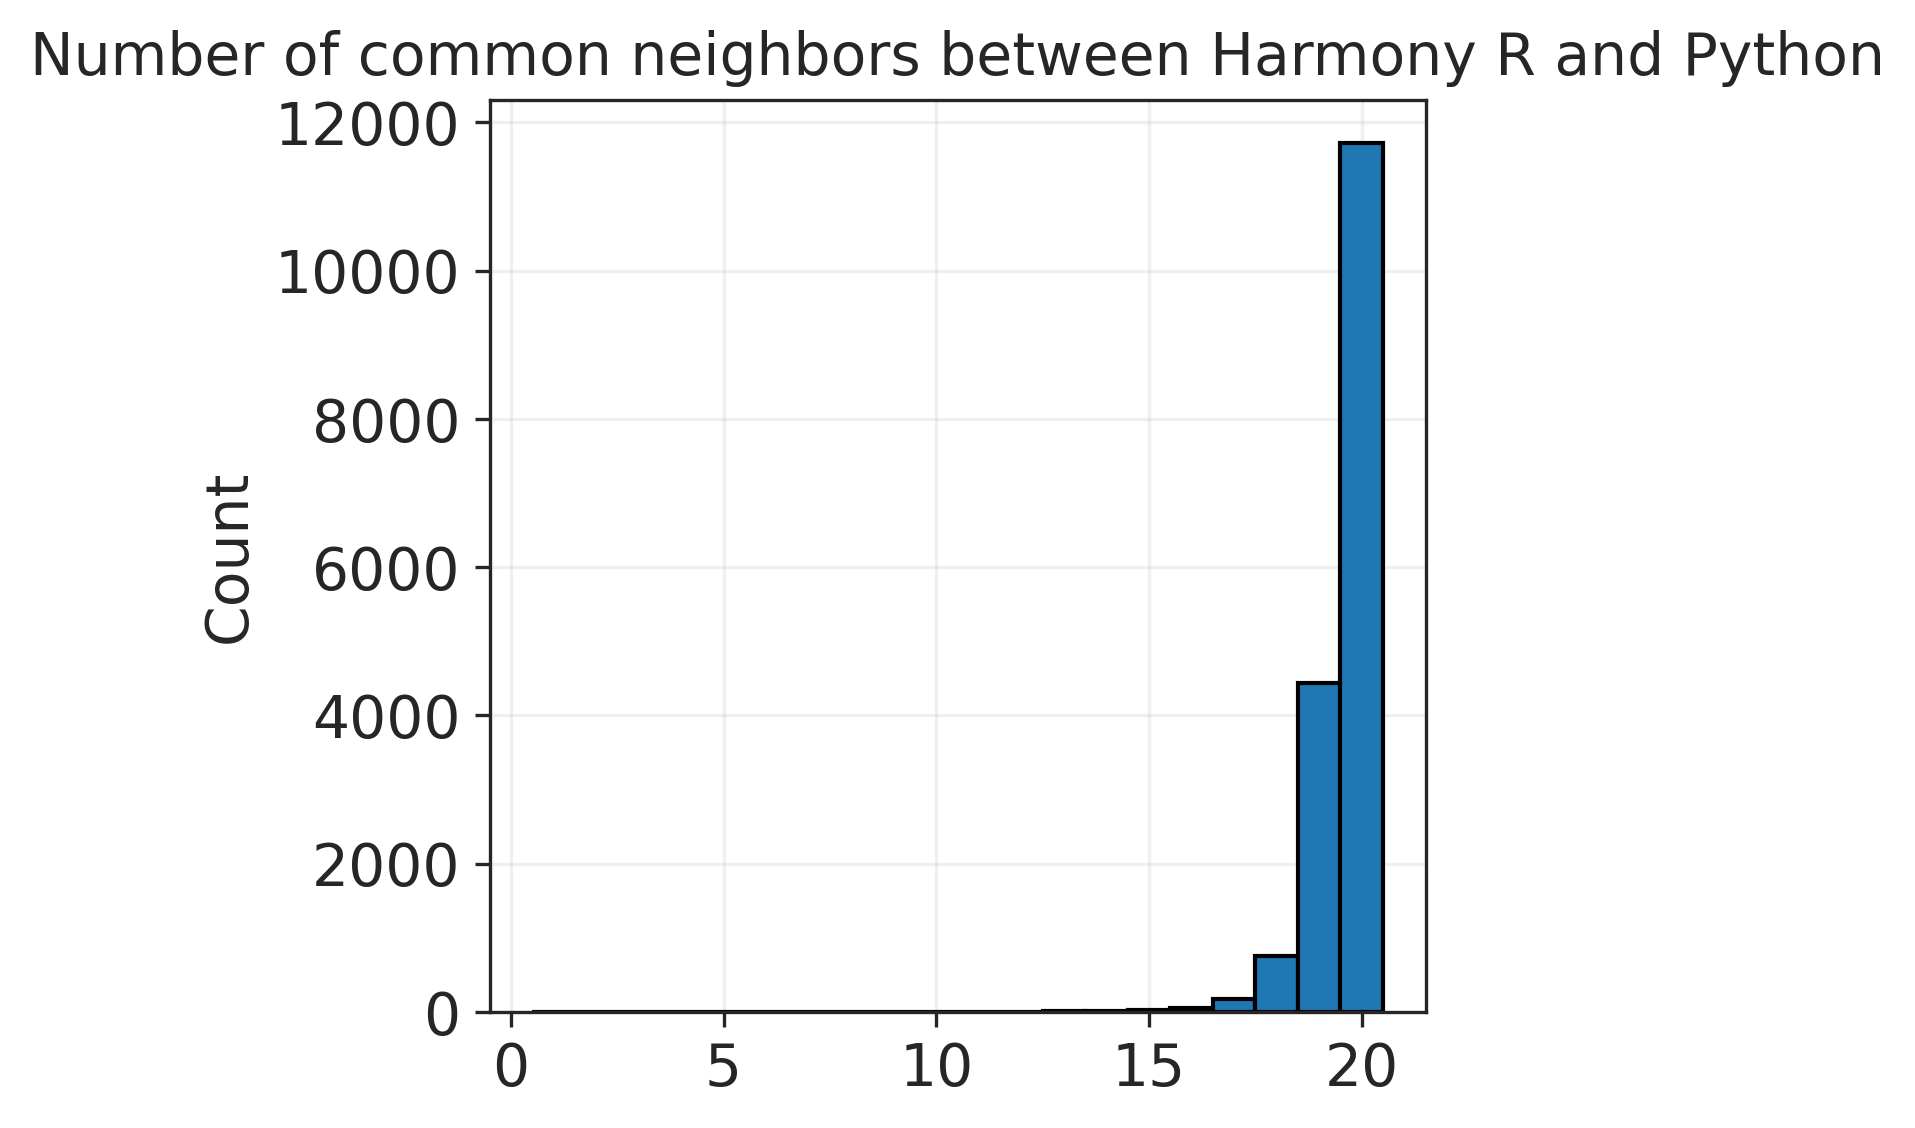

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(n_same, ax=ax, discrete=True, linewidth=1, edgecolor="black", alpha=1, legend=False)
ax.set_title("Number of common neighbors between Harmony R and Python")
ax.grid(alpha=0.3)

### Random restarts
- count once Harmony R to use as reference  
- restart Harmony R and harmonypy n_restarts times with different random states  
- count average of common neighbors between Harmony R results and reference,  
  and between harmonypy results and reference  
- compare averages

In [23]:
import logging
logging.basicConfig(level=logging.INFO,
                    force = True)
logger = logging.getLogger()
logger.info("oou")

INFO:root:oou


In [34]:
# import importlib
# importlib.reload(sp)
# importlib.reload(sp.pp)
# importlib.reload(sp.tl)
# importlib.reload(sp._utils)

<module 'symphonypy._utils' from '/home/ku/projs/symphony/symphonypy/_utils.py'>

In [24]:
def compare_harmony(
    lang,
    adata,
    my_pca_embeddings,
    random_seed,
    key,
    reference_neighbors,
    max_iter_harmony=20,
    verbose=False,
    **kwargs
):
    
    if lang == "py":
        ho = harmonypy.run_harmony(
            my_pca_embeddings, 
            meta_data,
            key,
            max_iter_harmony=max_iter_harmony,
            random_state=random_seed,
            verbose=verbose,
            **kwargs
        )
        converged = ho.check_convergence(1)
        adata.obsm["X_pca_harmony_Python"] = ho.Z_corr.copy().T
        use_rep = "X_pca_harmony_Python"
        key_added="Harmony_Python"
            
    elif lang == "R":
            kwargs["max.iter.harmony"] = max_iter_harmony

            sp._utils._harmony_integrate_R(
                adata,
                key,
                adjusted_basis="X_pca_harmony",
                random_seed=random_seed,
                verbose=verbose,
                **kwargs,
            )
            converged = adata.uns["harmony"]["converged"]
            use_rep = "X_pca_harmony"
            key_added="Harmony_R_restart"
    else:
        raise Exception(f"Unrealized language '{lang}' :)")

    if not converged:
        logger.warning(f"Not converged, lang: {lang}, max iterations: {max_iter_harmony}, random seed: {random_seed}")
    
    sc.pp.neighbors(adata, use_rep=use_rep, key_added=key_added, n_neighbors=n_neighbors)
    n_same = compare_neighbors(adata, reference_neighbors, f"{key_added}_distances")
    
    return n_same.mean()

In [25]:
n_restarts = 30

In [28]:
harmonypy_level = logging.getLogger('harmonypy').level
logging.getLogger('harmonypy').setLevel(logging.WARNING)

logger.warning("check")

average_R = np.zeros(n_restarts)
average_py = np.zeros(n_restarts)

for i in tqdm(range(n_restarts)):
    
    random_seed_i = random_seed + i + 1  # random_seed=random_seed was used for Harmony_R_distances
    
    average_R[i] = compare_harmony(
        "R", adata, my_pca_embeddings, random_seed_i, "donor", "Harmony_R_distances", **common_kwargs, **R_kwargs,
    )
    
    average_py[i] = compare_harmony(
        "py", adata, my_pca_embeddings, random_seed_i, "donor", "Harmony_R_distances", **common_kwargs, **py_kwargs,
    )
    
logging.getLogger('harmonypy').setLevel(harmonypy_level)

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
ttest_ind(average_R, average_py)

Ttest_indResult(statistic=-1.266084879757682, pvalue=0.21054442967693957)

In [ ]:
average_df = pd.DataFrame(
    {
        "average": np.concatenate([average_R, average_py]),
        "implementation": ["R"] * n_restarts + ["Python"] * n_restarts
    }
)

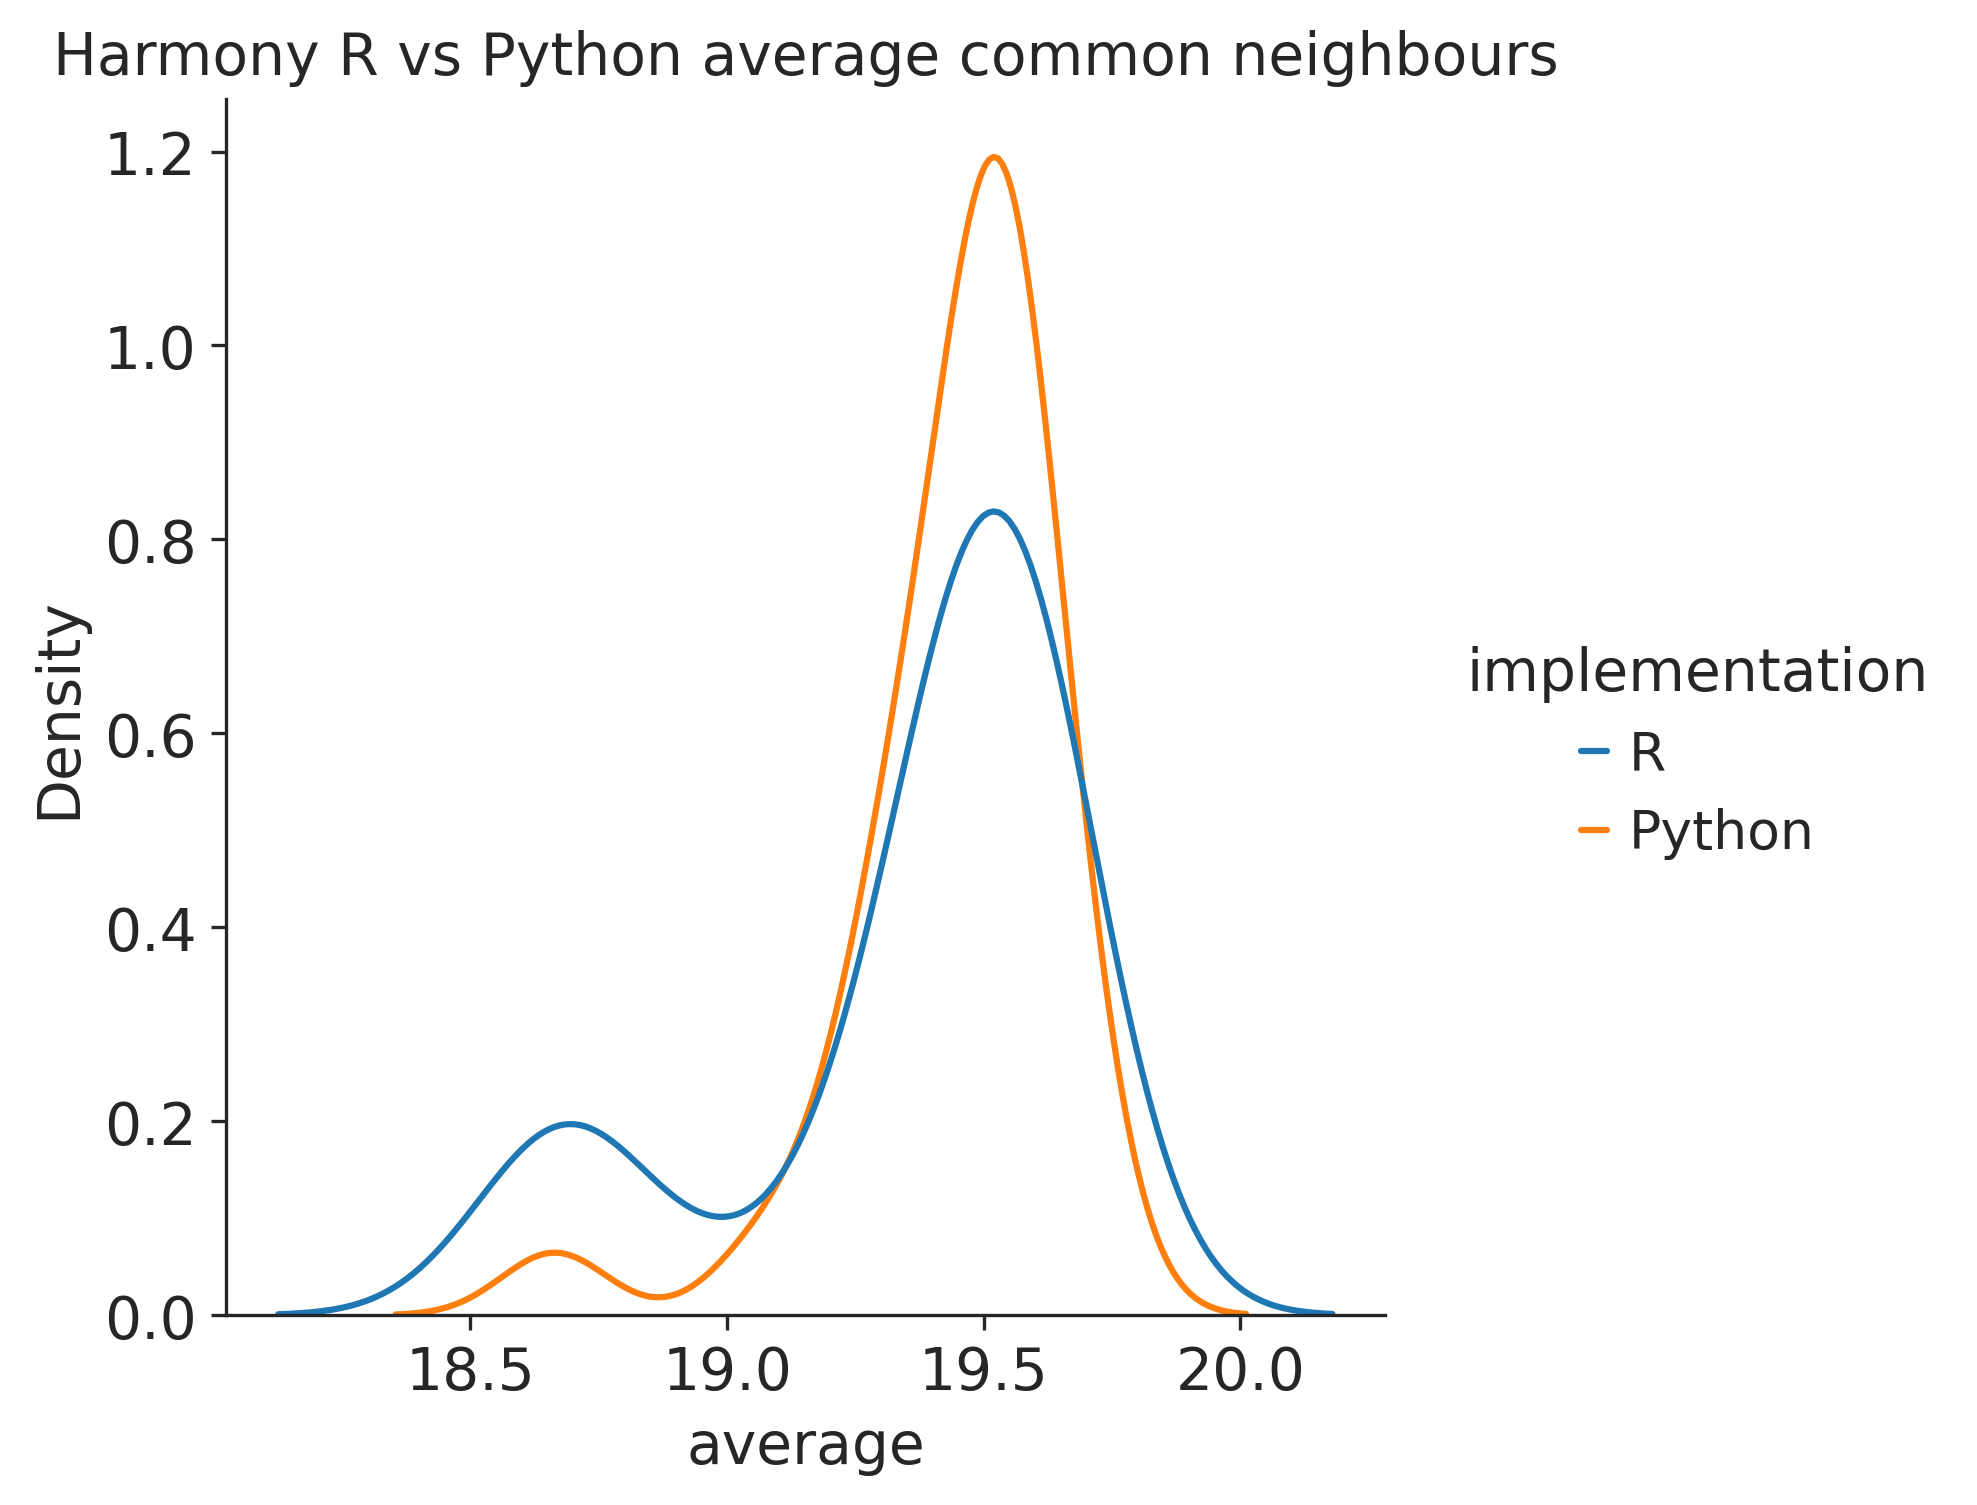

In [39]:
sns.displot(data=average_df, x="average", hue="implementation", kind="kde").set(title="Harmony R vs Python average common neighbours")

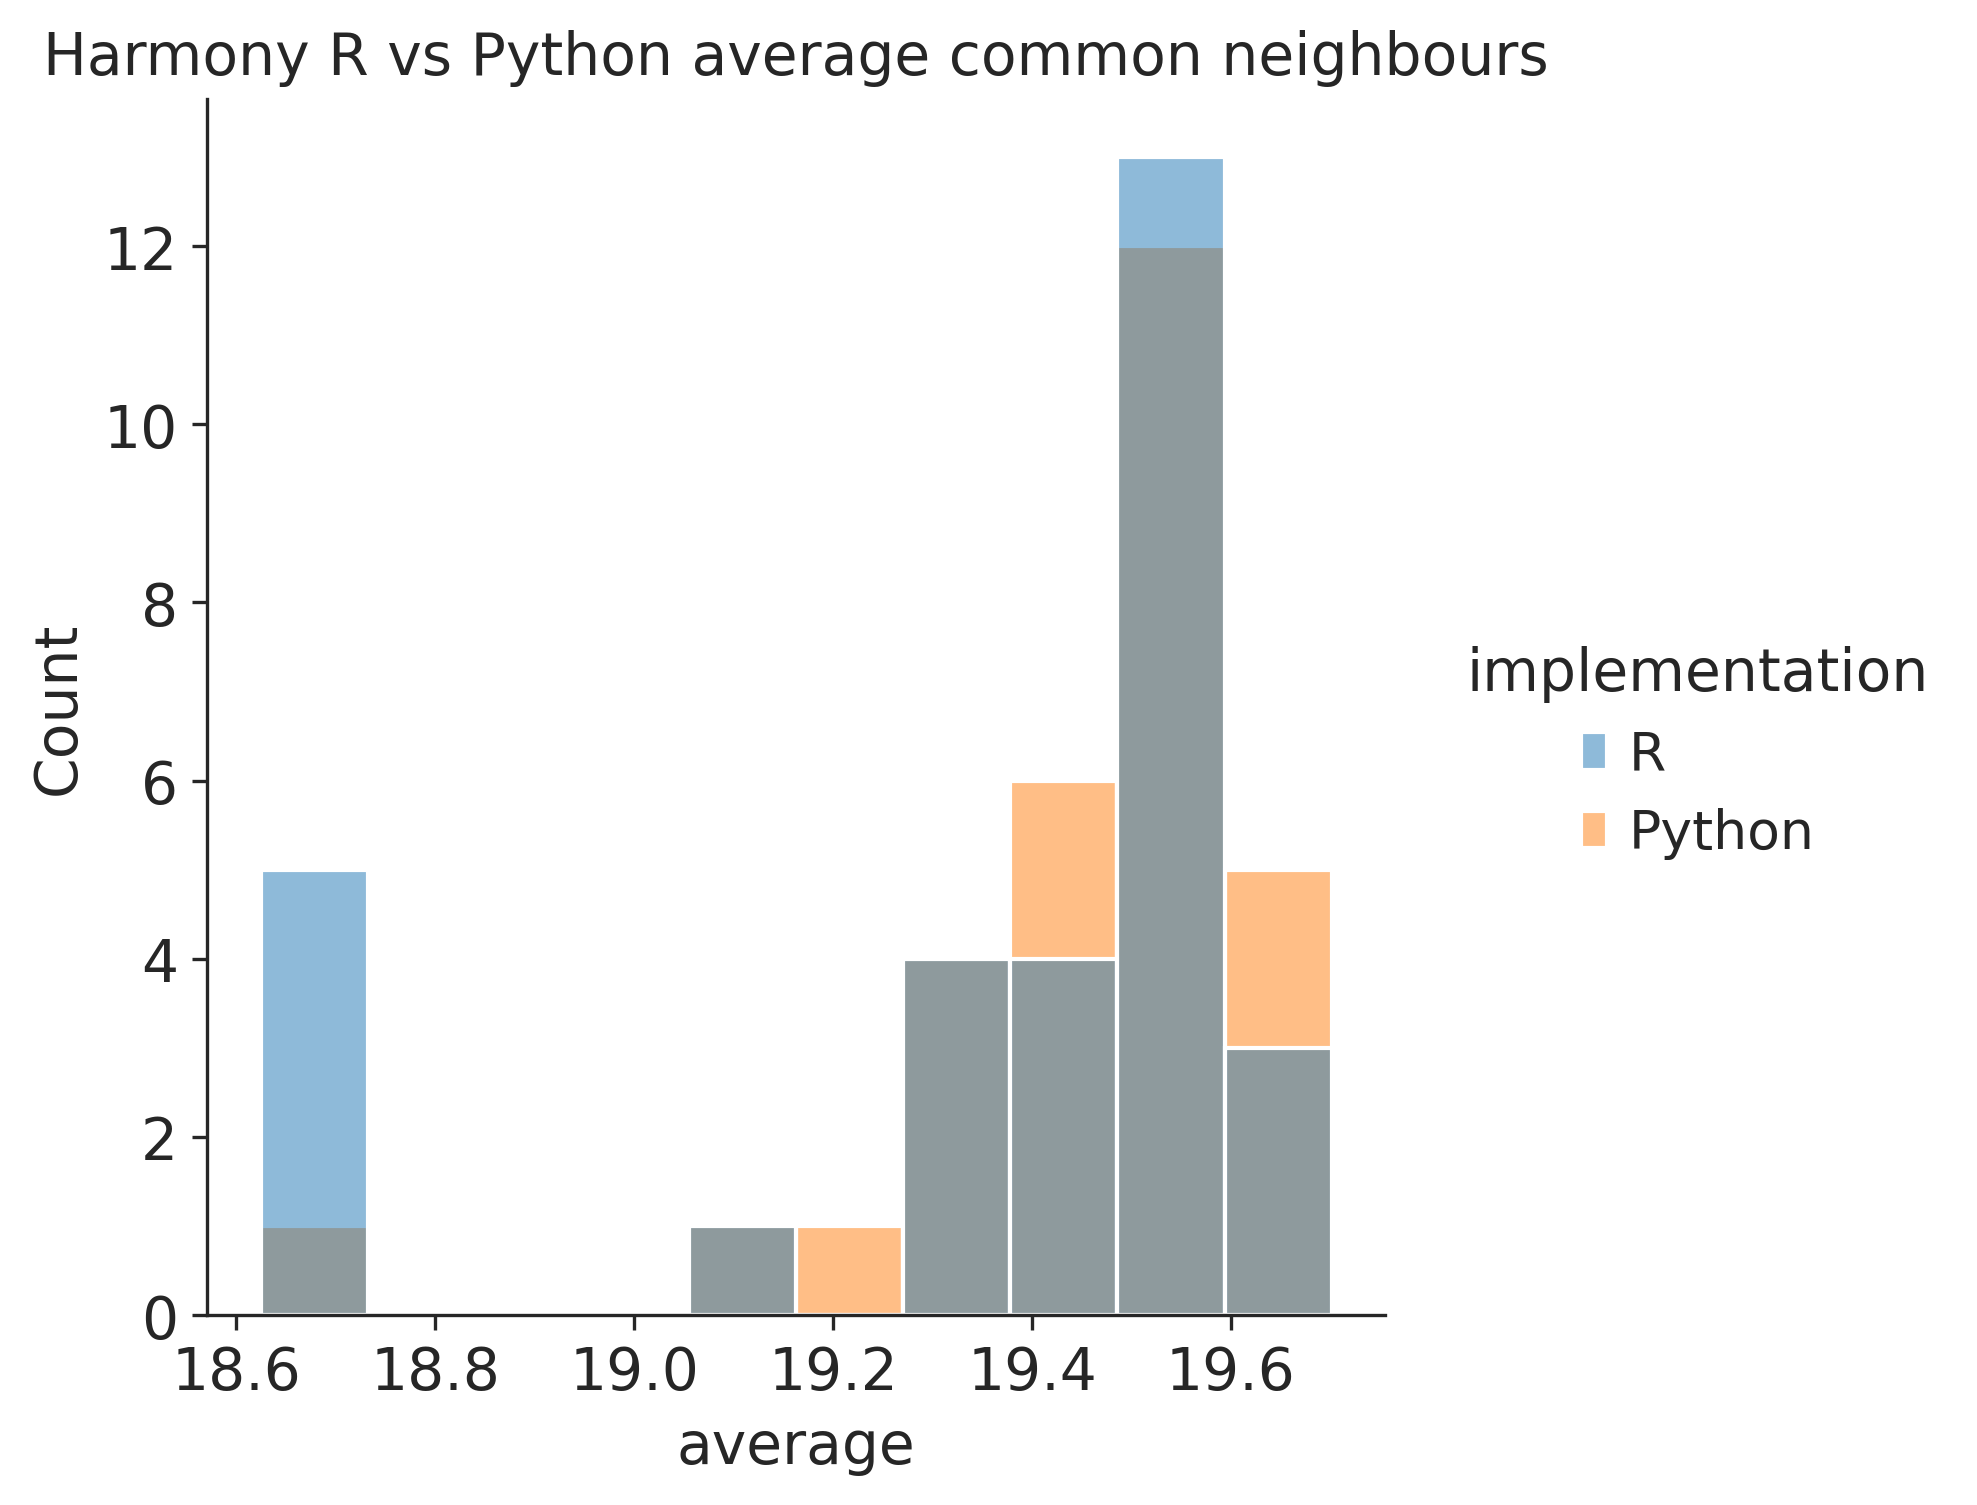

In [40]:
sns.displot(data=average_df, x="average", hue="implementation").set(title="Harmony R vs Python average common neighbours")

## Symphony

In [ ]:
# already normalized, scaled, PCA
adata_reference = adata.copy()

adata_query = sc.datasets.pbmc3k()
adata_query.var_names_make_unique()

sc.pp.normalize_total(adata_query)
sc.pp.log1p(adata_query)

In [ ]:
lamb = 1
labels = ['celltype.l1', 'celltype.l2', 'celltype.l3']

### Harmonypy + Symphonypy

In [ ]:
import symphonypy as sp

predicted_labels = [f"{label}_symphonypy" for label in labels]

In [ ]:
# import importlib
# importlib.reload(sp)
# importlib.reload(sp.pp)
# importlib.reload(sp.tl)
# importlib.reload(sp._utils)

In [ ]:
ref_basis_source = "X_pca"
basis_adjusted = "X_pca_harmony"

ref_basis_loadings = "PCs"
query_basis_ref = "X_pca_reference"

In [ ]:
sp.pp.harmony_integrate(
    adata_reference,
    ref_basis_source=ref_basis_source,
    ref_basis_adjusted=basis_adjusted,
    ref_basis_loadings=ref_basis_loadings,
    key="donor"
)

sp.tl.map_embedding(
    adata_reference,
    adata_query,
    lamb=lamb,
    adjusted_basis_query=basis_adjusted,
    query_basis_ref=query_basis_ref,
)

sp.tl.transfer_labels_kNN(
    adata_reference,
    adata_query,
    labels,
    predicted_labels,
    # kNN args
    n_neighbors,
    ref_basis=basis_adjusted,
    query_basis=basis_adjusted,
)

2023-01-03 20:30:49,629 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-01-03 20:31:04,697 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-01-03 20:31:04,909 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-01-03 20:31:14,506 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-01-03 20:31:24,067 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-01-03 20:31:34,183 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-01-03 20:31:42,287 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-01-03 20:31:53,474 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-01-03 20:32:03,049 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-01-03 20:32:08,518 - 

In [ ]:
sc.pp.neighbors(
    adata_reference,
    n_pcs=n_comps, n_neighbors=n_neighbors, knn=True, use_rep=basis_adjusted
)
sc.tl.umap(adata_reference)

In [ ]:
common_genes = list(set(adata_query.var_names).intersection(adata_reference.var_names))

adata_query_t = adata_query[:,common_genes].copy()

sc.tl.ingest(adata=adata_query_t, adata_ref=adata_reference[:,common_genes], embedding_method="umap")

In [ ]:
adata_query.obsm["X_umap"] = adata_query_t.obsm["X_umap"]

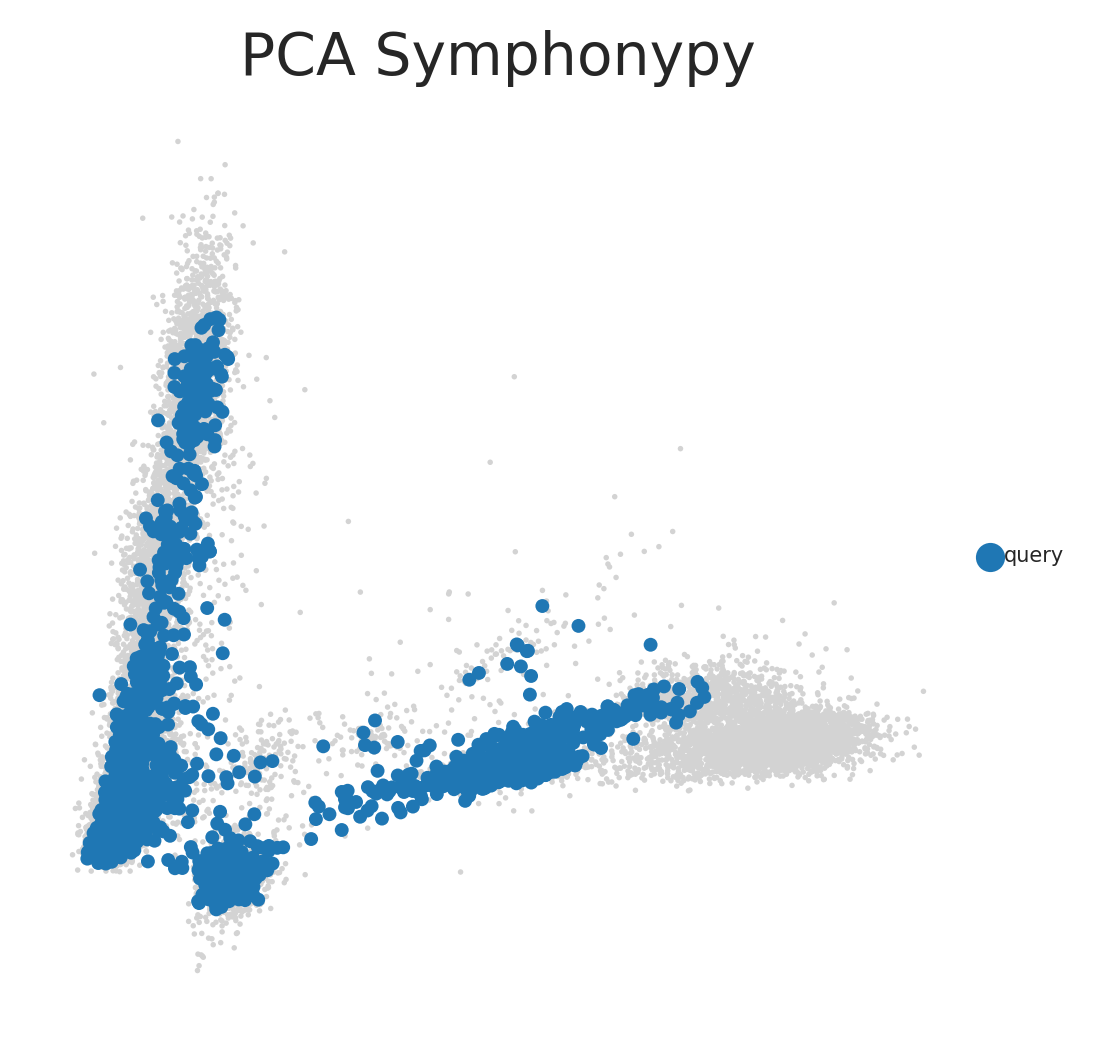

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "query"
sc.pl.embedding(adata_reference, basis=basis_adjusted, ax=ax, show=False, frameon=False)
sc.pl.embedding(adata_query, basis=basis_adjusted, ax=ax, show=False, color="Reference vs query",
                frameon=False, title="PCA Symphonypy")
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


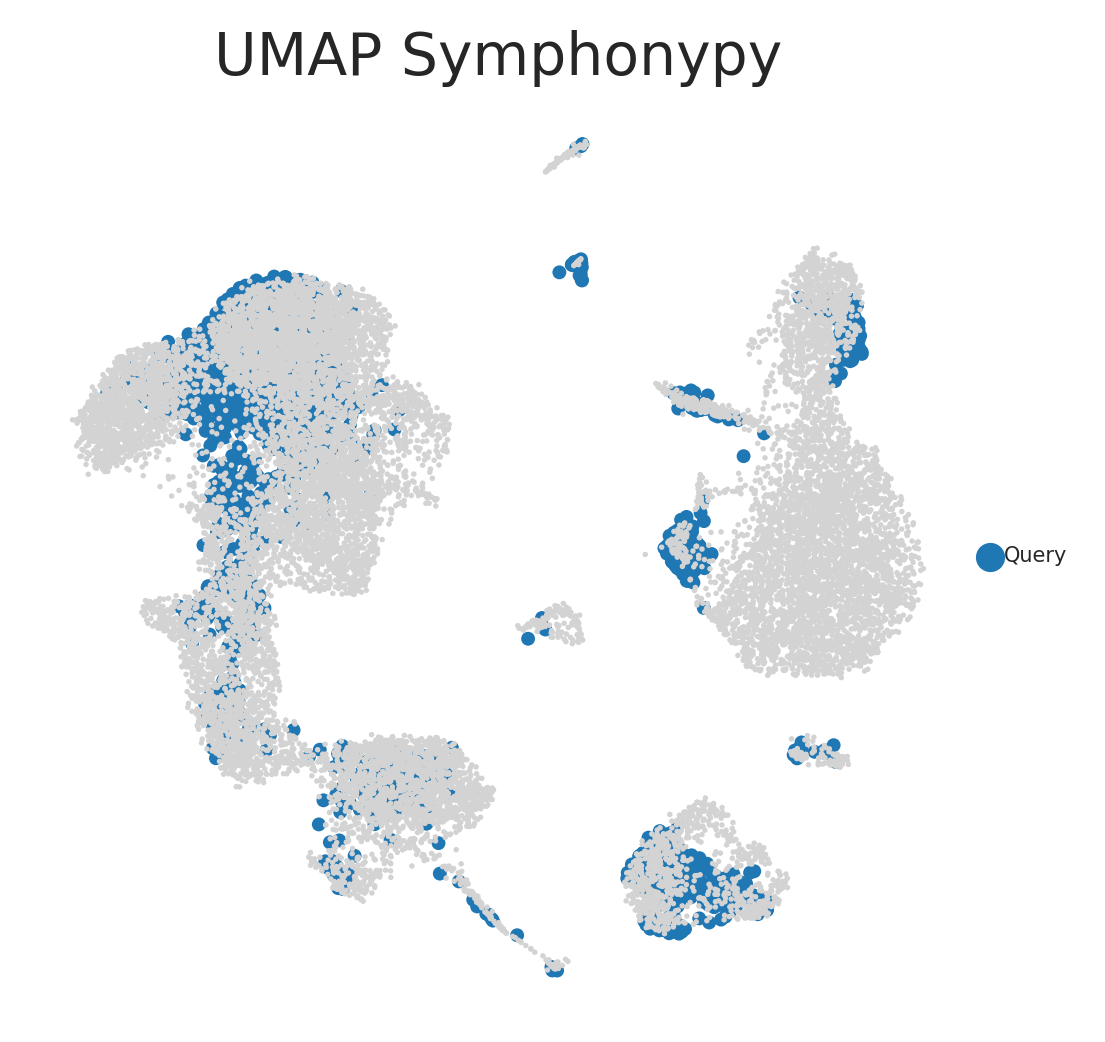

In [ ]:
fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "Query"
sc.pl.embedding(adata_query, basis="X_umap", ax=ax, show=False, color="Reference vs query", frameon=False)
sc.pl.embedding(adata_reference, basis="X_umap", ax=ax, show=False, frameon=False, title="UMAP Symphonypy")
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

In [ ]:
plt.rcParams.update({'legend.fontsize': 5})

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


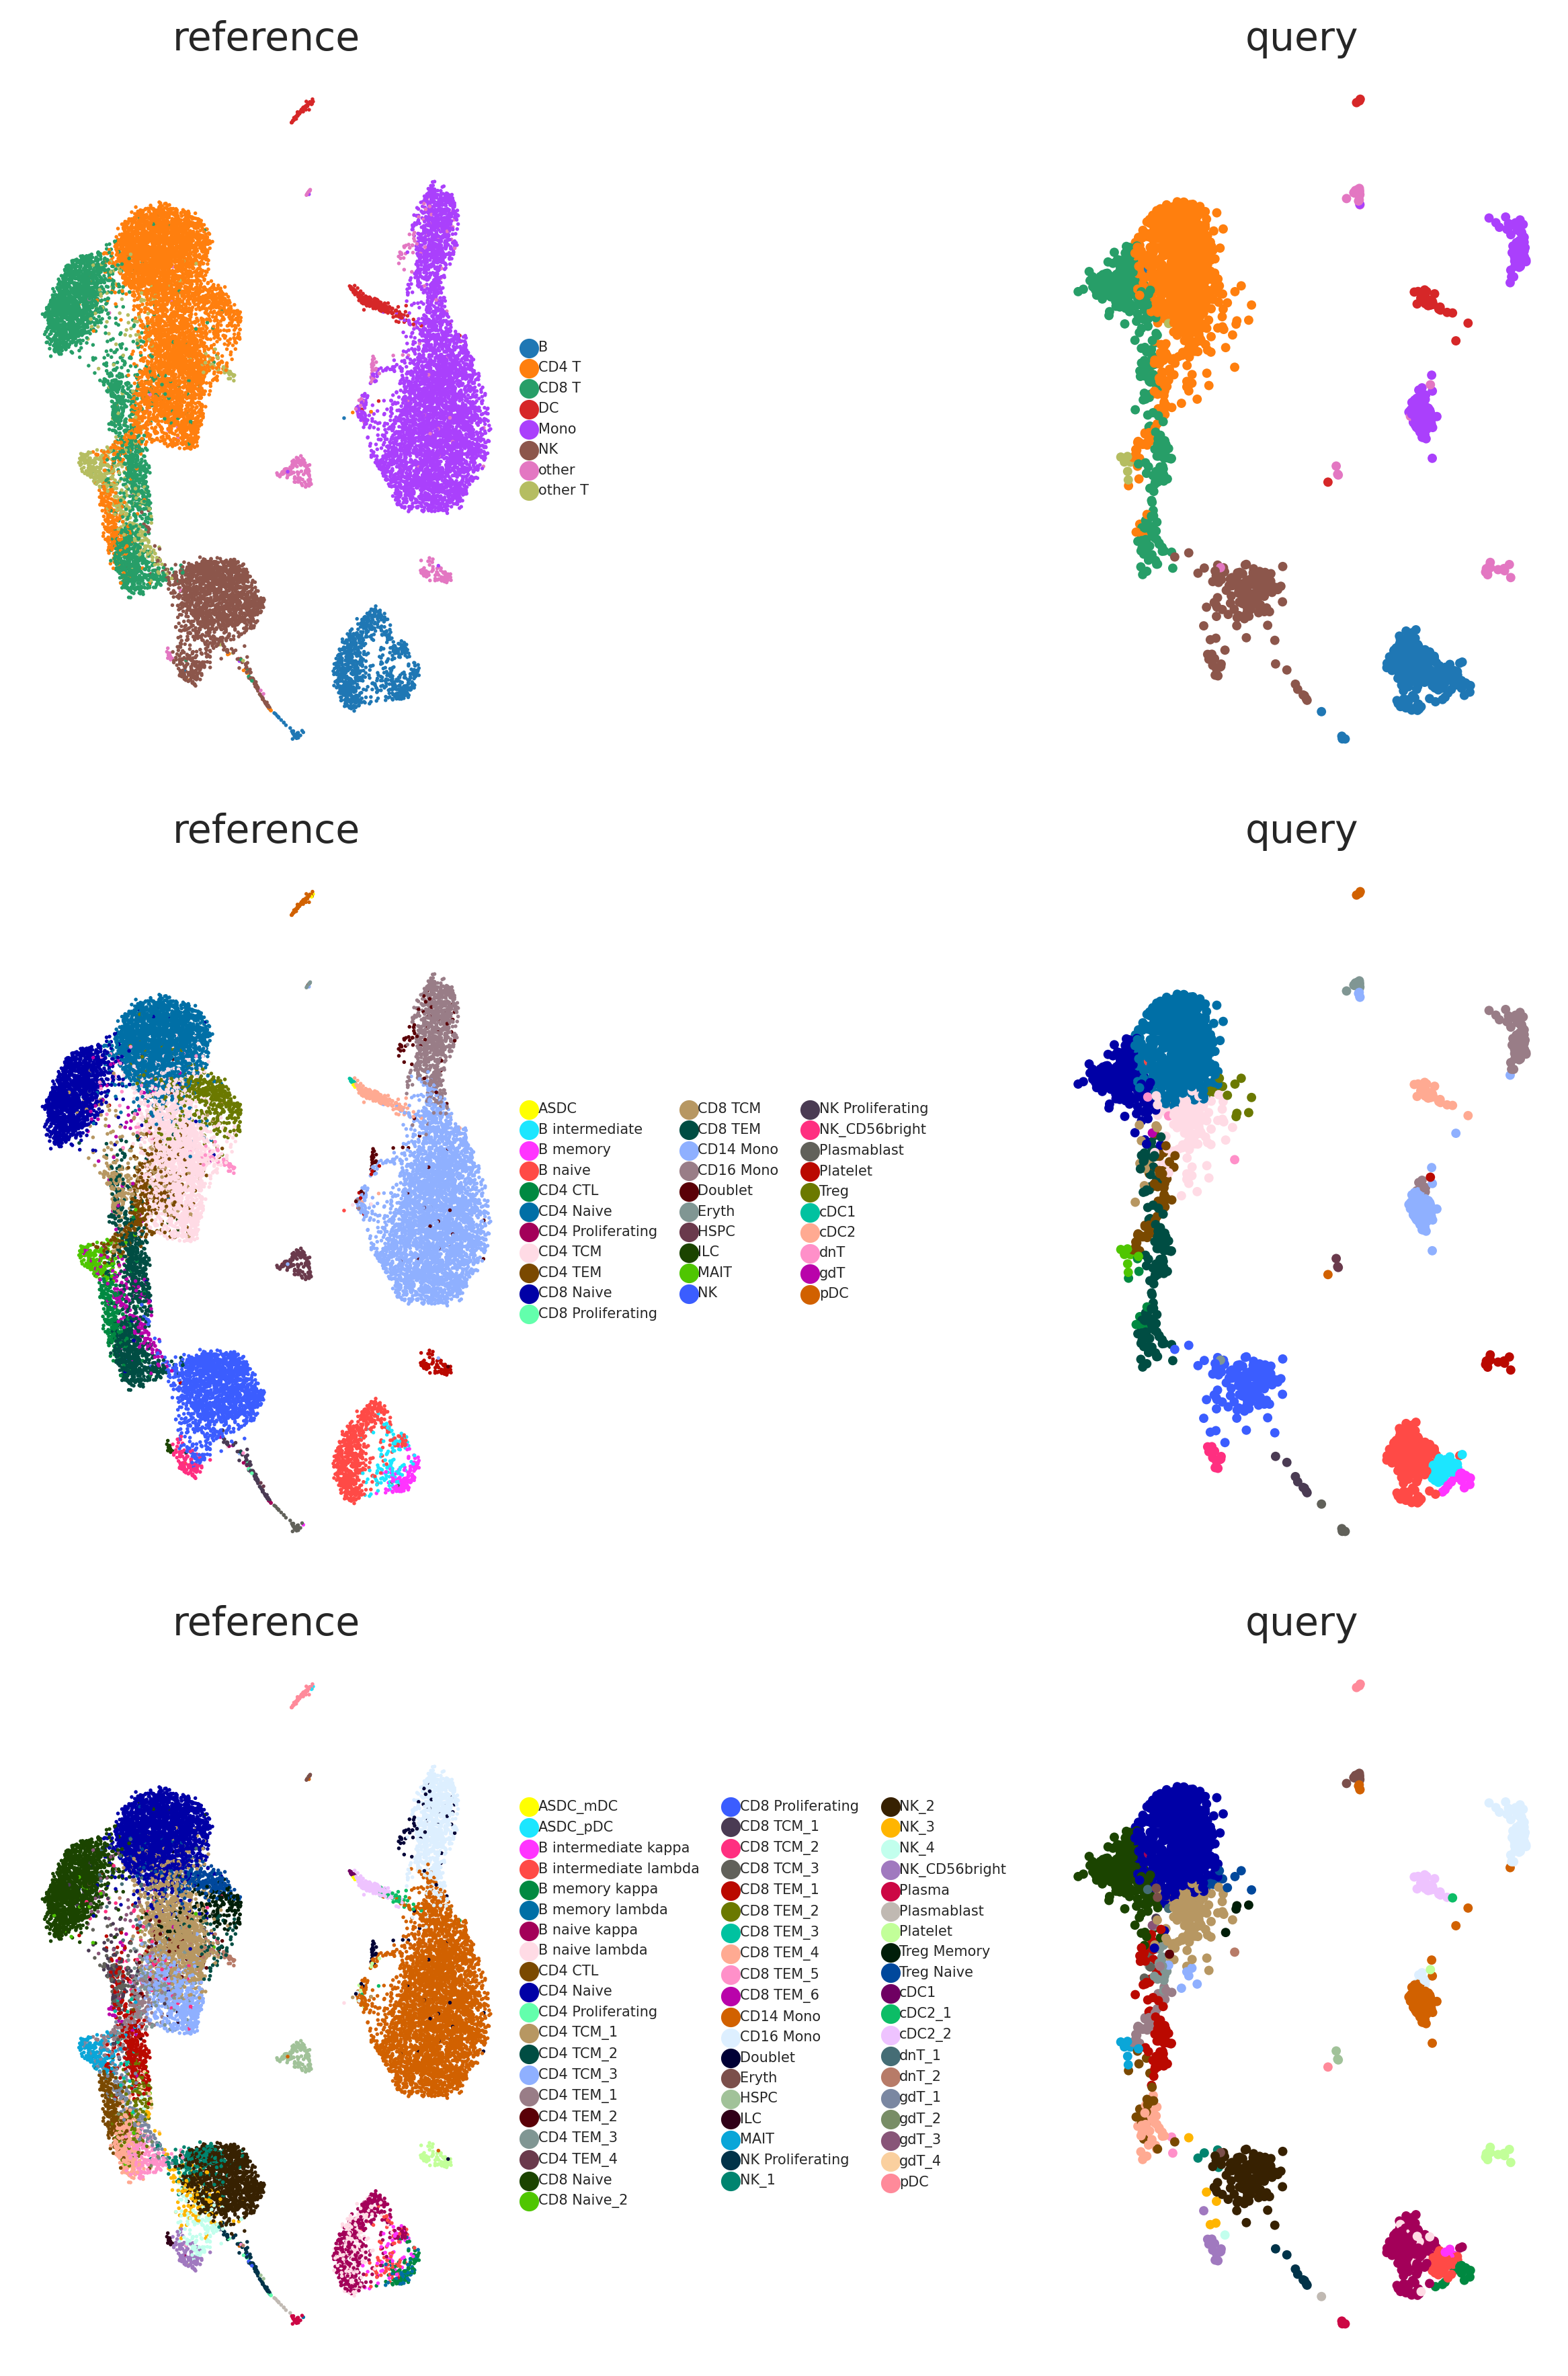

In [ ]:
fig, axs = plt.subplots(len(labels), 2, figsize=(8, len(labels)*4))

for i in range(len(labels)):
  
  sc.pl.embedding(
      adata_reference,
      basis="X_umap",
      ax=axs[i][0],
      show=False,
      frameon=False,
      color=labels[i],
      title="reference"
      )
  
  ref_l = adata_reference.obs[labels[i]].unique().sort_values()
  
  adata_query.uns[f'{predicted_labels[i]}_colors'] = np.array(
      adata_reference.uns[f"{labels[i]}_colors"])[ref_l.isin(adata_query.obs[predicted_labels[i]].unique().sort_values())]
  
  sc.pl.embedding(
      adata_query,
      basis="X_umap",
      ax=axs[i][1],
      show=False,
      color=predicted_labels[i],
      frameon=False,
      title="query",
      legend_loc=None
      )

fig.tight_layout()

### Harmony R + Symphony R

In [ ]:
var_genes = adata_reference.var_names[adata_reference.var.highly_variable]
gene_means = adata_reference.var.loc[var_genes, "mean"]
gene_sds = adata_reference.var.loc[var_genes, "std"]
loadings = adata_reference.varm["PCs"][adata_reference.var.highly_variable]

In [ ]:
%%R -i var_genes,gene_means,gene_sds

vargenes_means_sds <- data.frame(symbol = var_genes, mean = gene_means, stddev=gene_sds)

In [ ]:
%%R -i loadings
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           harmony_object,            # output object from HarmonyMatrix()
                           meta_data,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           do_umap = TRUE,
                           save_uwot_path = './testing_uwot_model_1'
                           )

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
UMAP
File already exists at that path... overwriting...
Saved uwot model
Finished nicely.


In [ ]:
query_exp = adata_query.X.A.T
query_metadata = adata_query.obs
gene_names = adata_query.var_names

In [ ]:
%%R -i query_exp,query_metadata,gene_names
rownames(query_exp) <- gene_names

In [ ]:
%%R
# Map query
query = symphony::mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE,
                 )

Scaling and synchronizing query gene expression
Found 2552 out of 3000 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
UMAP
All done!


In [ ]:
%%R -o X_pca_symphony_R,X_umap_symphony_R
# names(query)
X_pca_symphony_R <- query$Z
X_umap_symphony_R <- query$umap

In [ ]:
adata_query.obsm["X_pca_symphony_R"] = X_pca_symphony_R.T
adata_query.obsm["X_umap_symphony_R"] = X_umap_symphony_R

In [ ]:
predicted_labels_R = [f"{label}_symphonyR" for label in labels]

In [ ]:
sp.tl.transfer_labels_kNN(
    adata_reference,
    adata_query,
    labels,
    predicted_labels_R,
    # kNN args
    n_neighbors,
    ref_basis="X_pca_harmony_R",
    query_basis="X_pca_symphony_R",
)

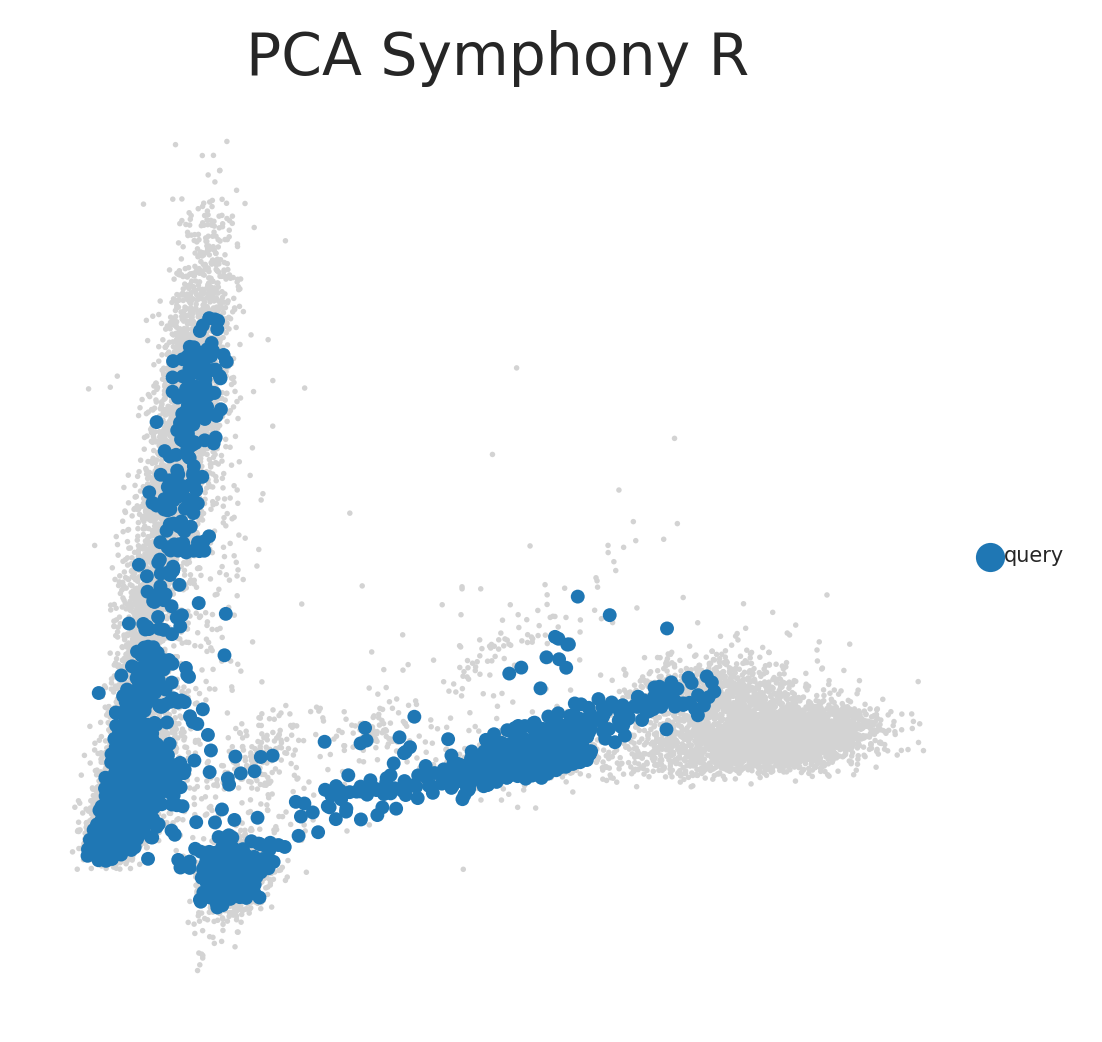

In [ ]:
fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "query"
sc.pl.embedding(adata_reference, basis="X_pca_harmony_R", ax=ax, show=False, frameon=False)
sc.pl.embedding(adata_query, basis="X_pca_symphony_R", ax=ax, show=False, color="Reference vs query",
                frameon=False, title="PCA Symphony R")
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

In [ ]:
%%R -o X_umap_harmony_R
X_umap_harmony_R <- reference$umap$embedding

In [ ]:
adata_reference.obsm["X_umap_harmony_R"] = X_umap_harmony_R

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


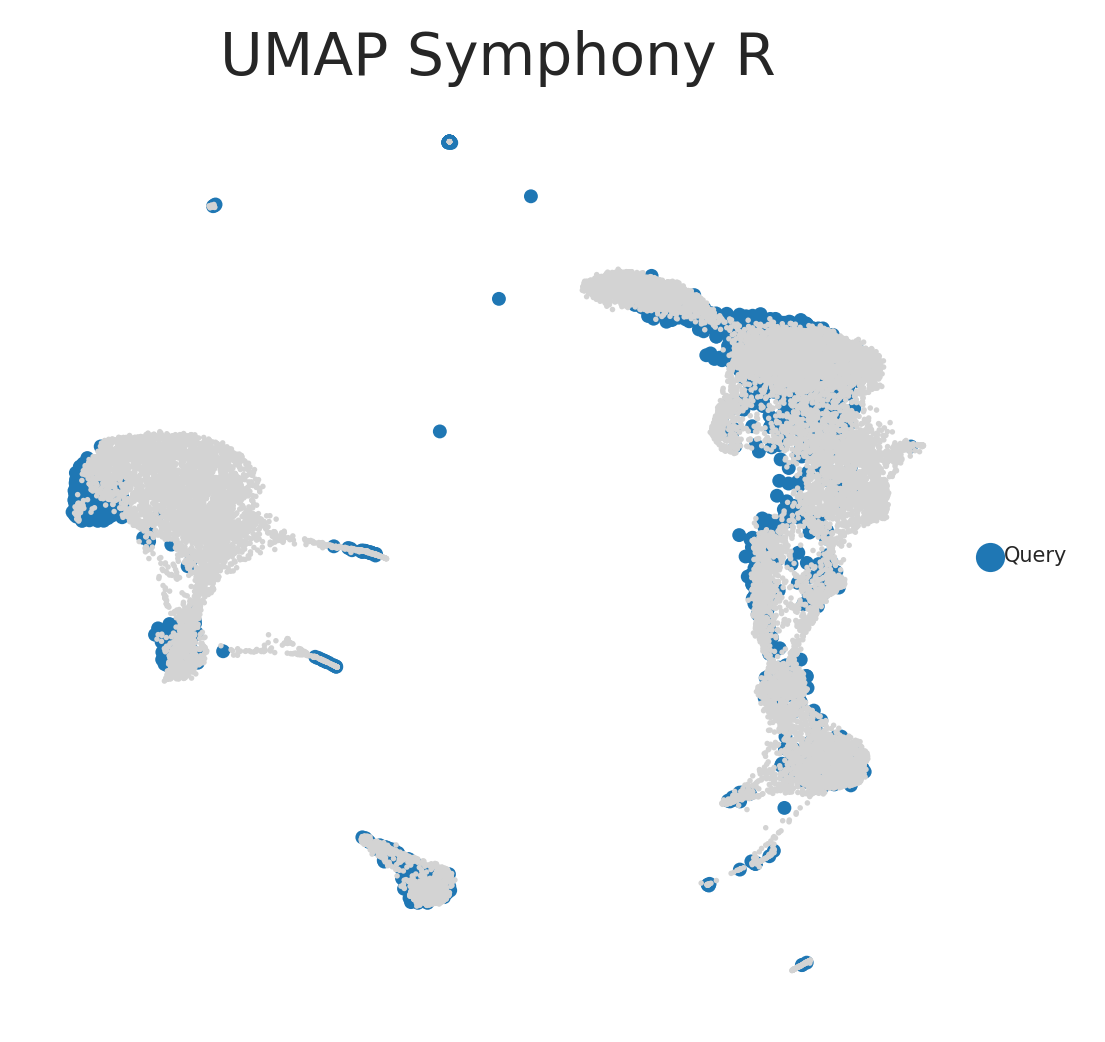

In [ ]:
fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "Query"
sc.pl.embedding(adata_query, basis="X_umap_symphony_R", ax=ax, show=False, color="Reference vs query", frameon=False)
sc.pl.embedding(adata_reference, basis="X_umap_harmony_R", ax=ax, show=False, frameon=False, title="UMAP Symphony R")
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


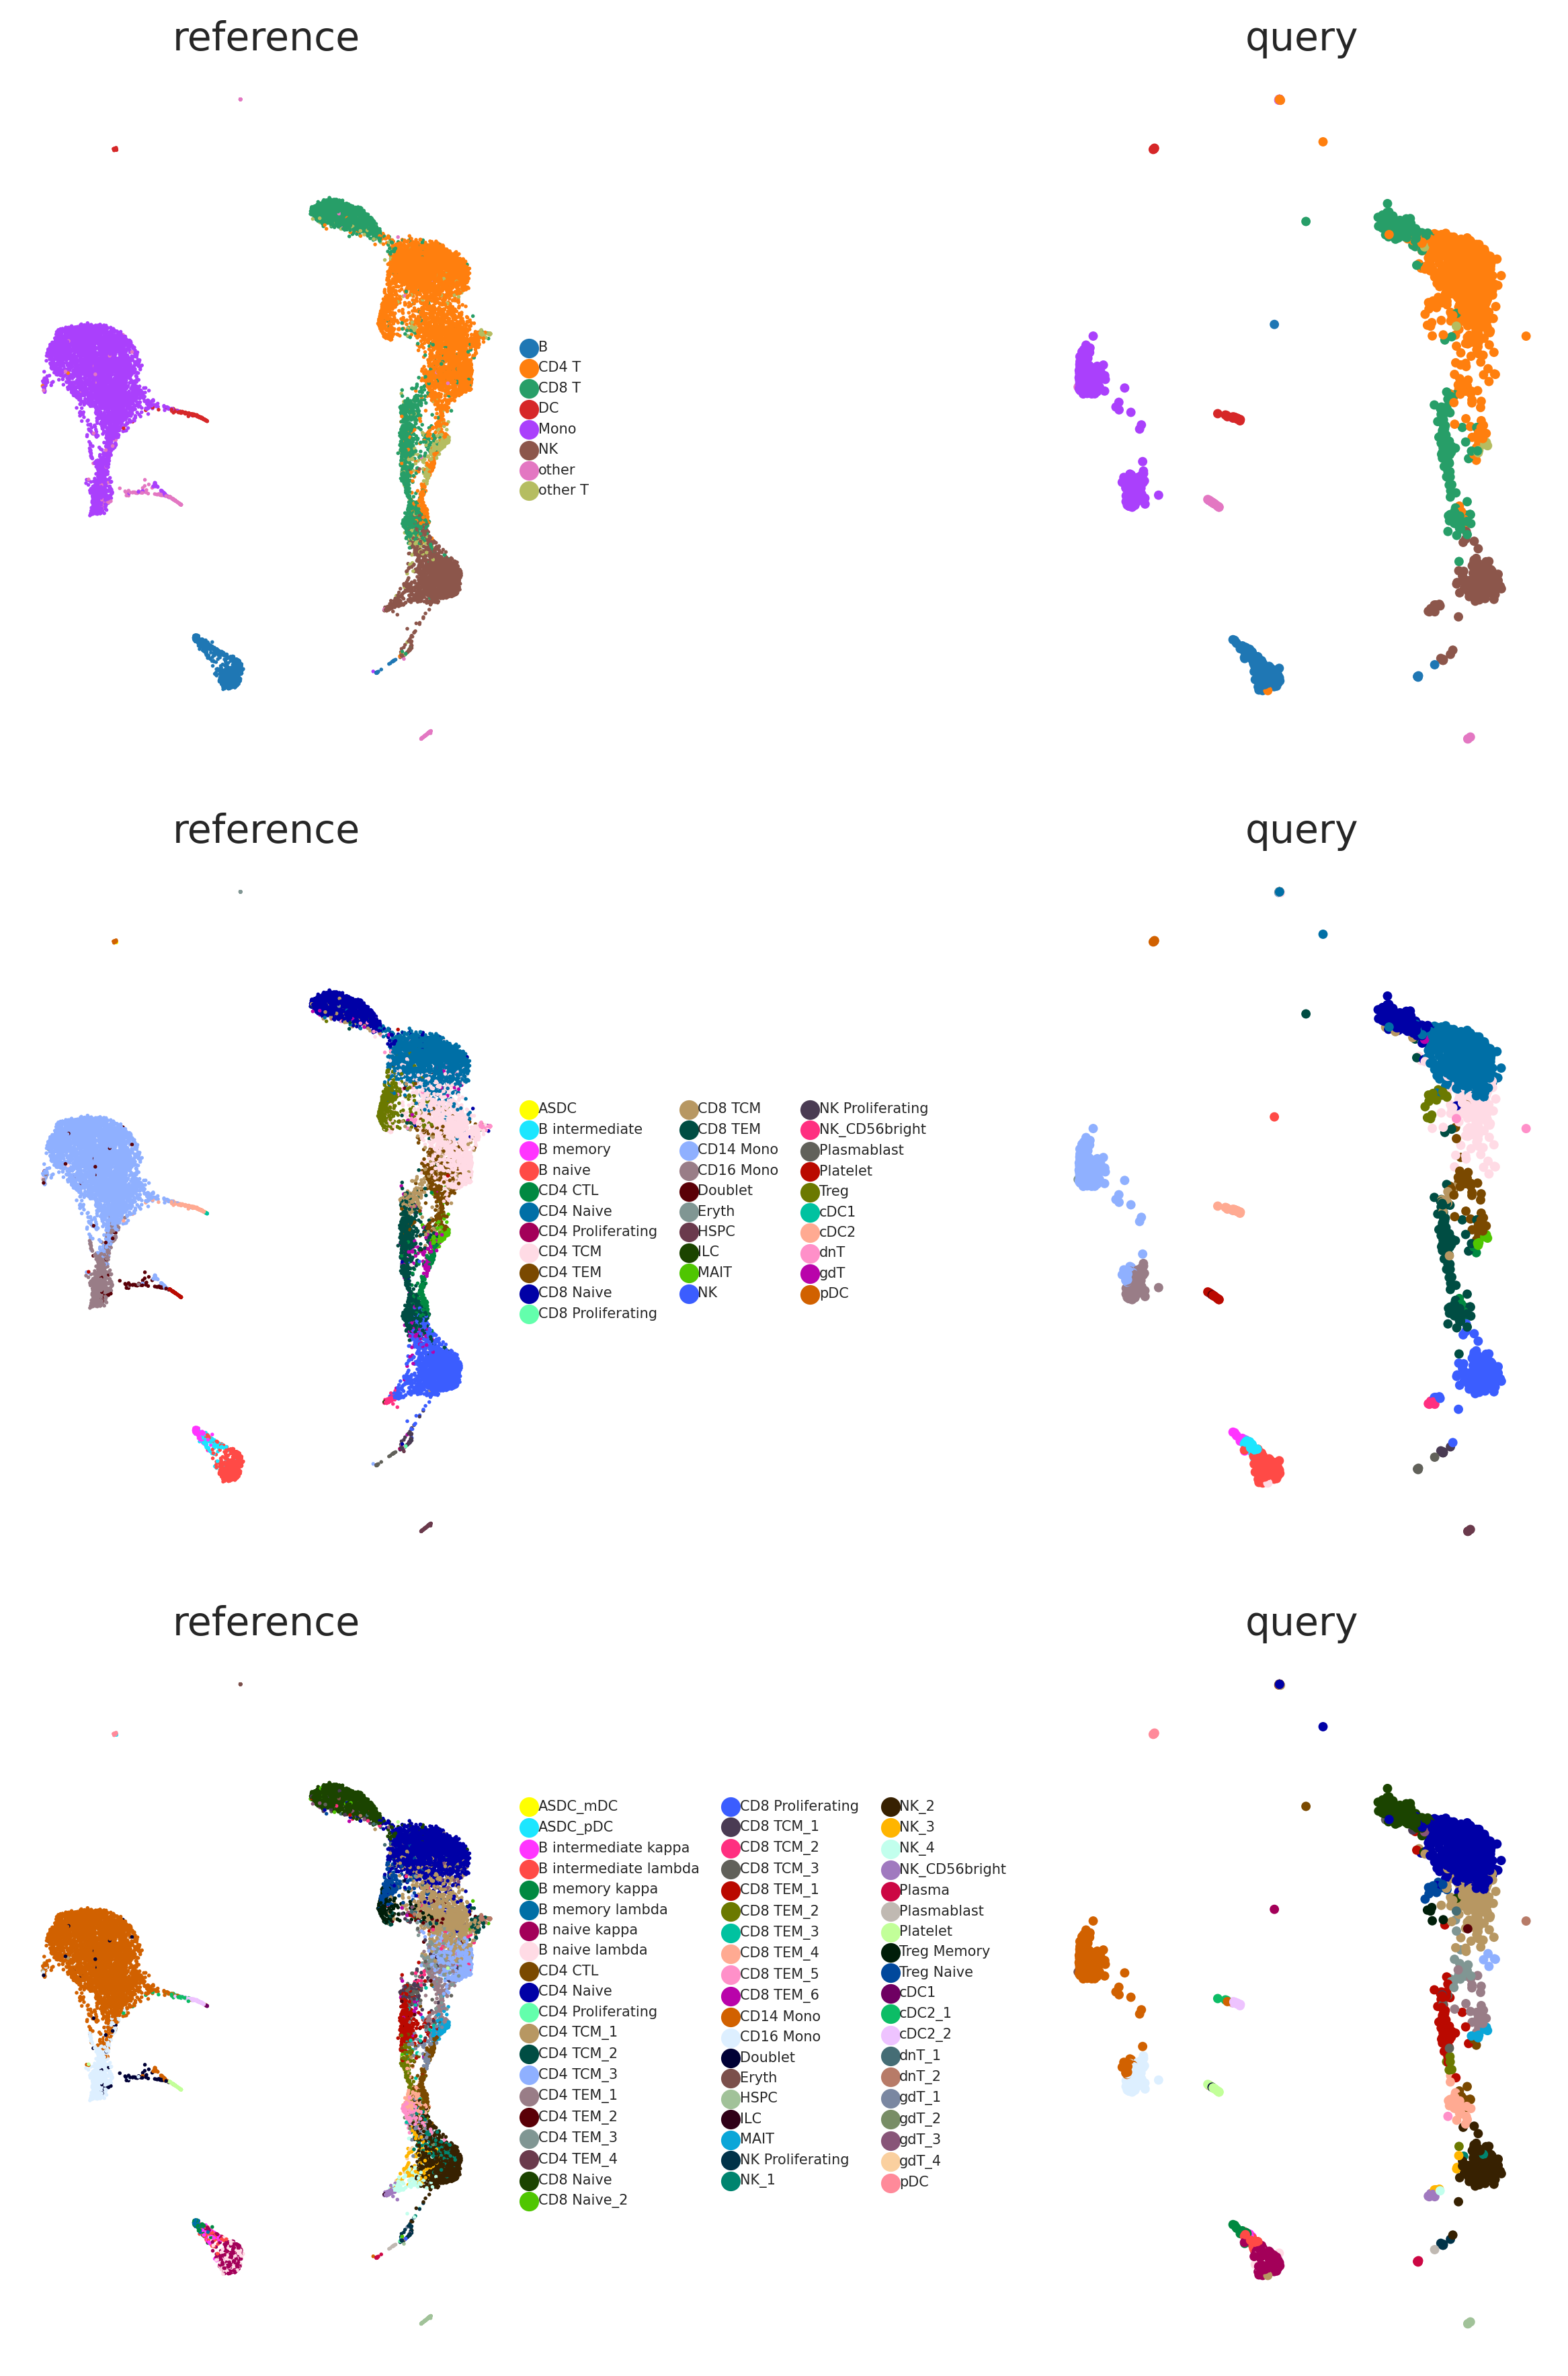

In [ ]:
fig, axs = plt.subplots(len(labels), 2, figsize=(8, len(labels)*4))

for i in range(len(labels)):
  
  sc.pl.embedding(
      adata_reference,
      basis="X_umap_harmony_R",
      ax=axs[i][0],
      show=False,
      frameon=False,
      color=labels[i],
      title="reference"
      )
  
  ref_l = adata_reference.obs[labels[i]].unique().sort_values()
  
  adata_query.uns[f'{predicted_labels_R[i]}_colors'] = np.array(
      adata_reference.uns[f"{labels[i]}_colors"]
      )[ref_l.isin(adata_query.obs[predicted_labels_R[i]].unique().sort_values())]
  
  sc.pl.embedding(
      adata_query,
      basis="X_umap_symphony_R",
      ax=axs[i][1],
      show=False,
      color=predicted_labels_R[i],
      frameon=False,
      title="query",
      legend_loc=None
      )

fig.tight_layout()

## (Harmony + Symphony) R vs py

Number of common neighbors from reference in query by R and python

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
adata_query

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype.l1_symphonypy', 'celltype.l2_symphonypy', 'celltype.l3_symphonypy', 'celltype.l1_symphonyR', 'celltype.l2_symphonyR', 'celltype.l3_symphonyR'
    var: 'gene_ids'
    uns: 'log1p', 'celltype.l1_symphonypy_colors', 'celltype.l2_symphonypy_colors', 'celltype.l3_symphonypy_colors', 'celltype.l1_symphonyR_colors', 'celltype.l2_symphonyR_colors', 'celltype.l3_symphonyR_colors'
    obsm: 'X_pca_reference', 'X_pca_harmony', 'X_umap', 'X_pca_symphony_R', 'X_umap_symphony_R'

In [ ]:
knn = NearestNeighbors(n_neighbors=n_neighbors)

In [ ]:
adata_reference

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'n_same_cells'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'donor_colors', 'Harmony_R', 'Harmony_Python', 'harmony', 'neighbors', 'umap', 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors'
    obsm: 'X_pca', 'X_pca_harmony_R', 'X_pca_harmony_Python', 'X_pca_harmony', 'X_umap', 'X_umap_harmony_R'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'Harmony_R_distances', 'Harmony_R_connectivities', 'Harmony_Python_distances', 'Harmony_Python_connectivities', 'distances', 'connectivities'

In [ ]:
# R
knn.fit(adata_reference.obsm["X_pca_harmony_R"])
distance_mat_R, neighbors_mat_R = knn.kneighbors(adata_query.obsm["X_pca_symphony_R"])

In [ ]:
adata_query.obsm["Harmony_R_distances"] = distance_mat_R
adata_query.obsm["Harmony_R_neighbors"] = neighbors_mat_R

In [ ]:
# Python
knn.fit(adata_reference.obsm["X_pca_harmony_Python"])
distance_mat_py, neighbors_mat_py = knn.kneighbors(adata_query.obsm["X_pca_harmony"])

In [ ]:
adata_query.obsm["Harmony_R_distances"] = distance_mat_py
adata_query.obsm["Harmony_R_neighbors"] = neighbors_mat_py

In [ ]:
n_common_symphony = np.zeros(adata_query.shape[0])

for i in range(adata_query.shape[0]):
  n_common_symphony[i] = len(set(neighbors_mat_R[i]).intersection(set(neighbors_mat_py[i])))

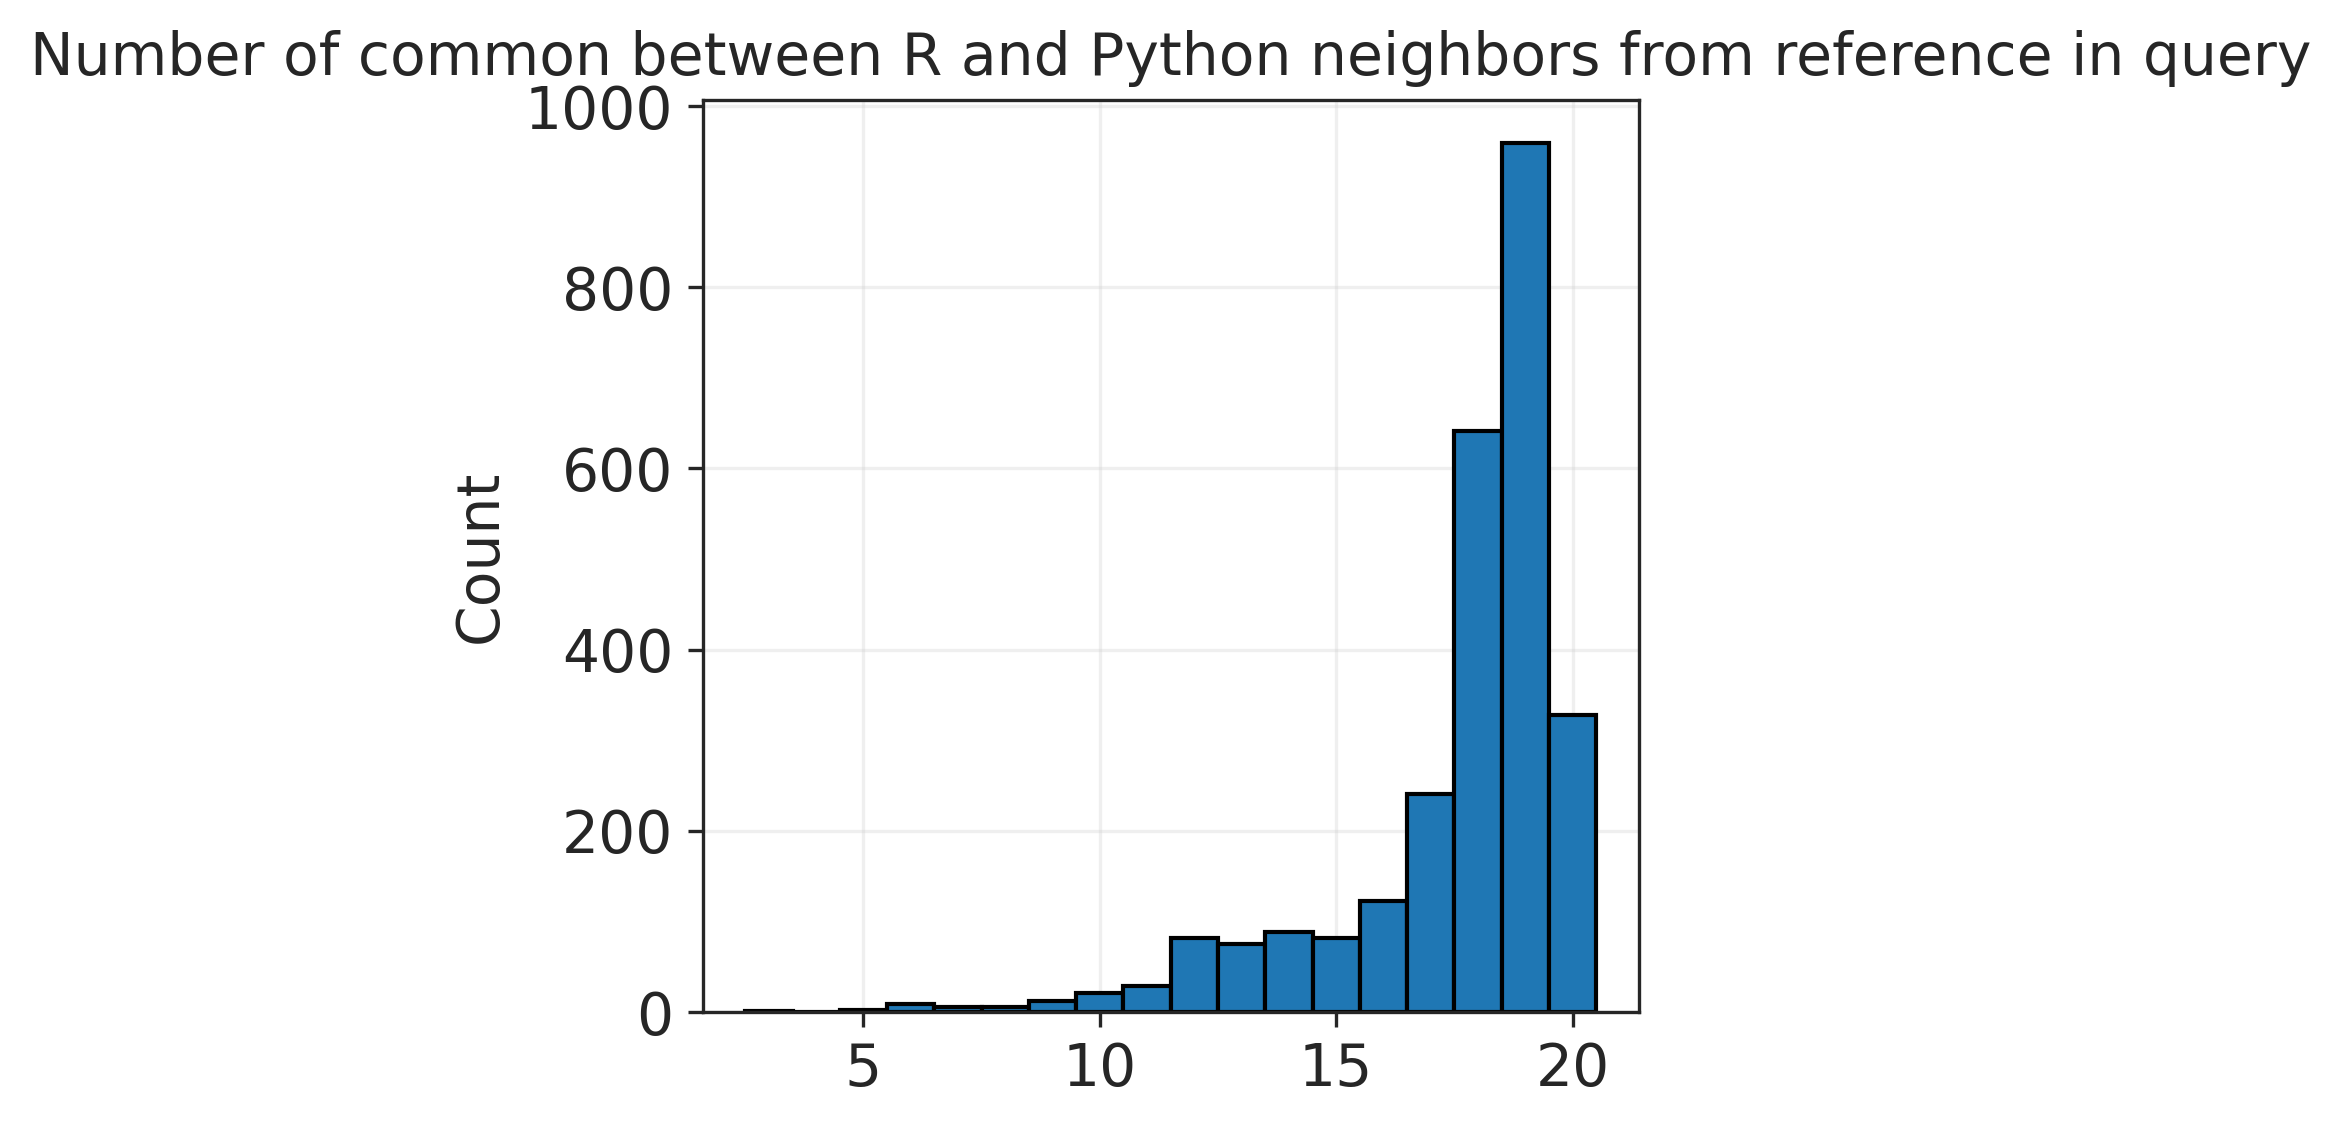

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(n_common_symphony, ax=ax, discrete=True, linewidth=1, edgecolor="black", alpha=1)
ax.set_title("Number of common between R and Python neighbors from reference in query")
ax.grid(alpha=0.3)

Comparison of cell_type prediction accuracy between R and python